## Final Project : IBM Data Science Capstone Project 

#### Importing modules 

In [29]:
import pandas as pd 
import geocoder
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [106]:
import re # text processing
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns 
sns.set_style('darkgrid')

#### scrapping wikipedia page

In [34]:
page = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/Algiers#Geography').content, "html.parser")
links = page.find_all('tr')
neighs = []
for i in range(len(links)):
    neighs.append(re.findall('<.+>\n<.+>(.+)\n</.+>\n<.+>(.+)\n<.+>\n<.+>(.+)\n<.+><.+>',str(links[i])))

#### loading data

In [35]:
# list of neighborhoods : 
neighs = ['Bab El Oued','Bologhine','Casbah','Oued Koriche','Raïs Hamidou','Baraki','Les Eucalyptus','Sidi Moussa','Bir Mourad Raïs','Ben Aknoun','Beni Messous',
         'Birkhadem','Djasr Kasentina','Hydra','Birtouta','Bouzareah','El Biar','Aïn Bénian','Chéraga','Aïn Taya','Bab Ezzouar','Bordj El Bahri','Bordj El Kiffan',
          'Ouled Fayet','Dely Ibrahim','Dar El Beïda','Draria','Bourouba','Baba Hassen','Douera','Mohammedia','El Marsa','El Harrach','Oued Smar','Hussein Dey',
         'Kouba','Mohamed Belouizdad','Haraoua','Reghaïa','El Mouradia','Alger Centre','Sidi M\'Hamed','Staoueli','Zéralda']
val_adds = []
latitudes = []
longitudes = []
geolocator = Nominatim(user_agent="on_explorer")


# Using geolocator to extract longitude and latitue of each neighborhood 
for code in neighs:
    address = '{}'.format(code)
    location = geolocator.geocode(address)
    try : 
        latitude = location.latitude
        longitude = location.longitude
    except:pass   
    if latitude is not None and longitude is not None :
        val_adds.append(address)
        latitudes.append(latitude)
        longitudes.append(longitude)
    

In [41]:
# evaluating our operation
print(val_adds == neighs)
print('we extracted {} out of {} location'.format(len(val_adds),len(neighs)))

True
we extracted 44 out of 44 location


In [42]:
# Using  Foursquare API ( my personal account credentials)
client_id = 'YTK1NYRQ0PYOI5JB2IUMJK3VGYQXTI0QEVTUGDBWCQ3AYZCG'
client_secret= '3OZMRXXPE31NLIAHXRCPS01WWFVGDH4NGCLMUMSX3S0TDXSE'
version = '20180605'
limit = 100000

In [43]:
# Creating a function that uses Foursquare API and extracting near-by venues with 50000 radius , and than creating a the wanted dataframe

def getNearbyVenues2(names, latitudes, longitudes, radius=50000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        if 36<lat<37 and 2<lng<4 : 

            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('all retrieved')
    return(nearby_venues)

In [45]:
# Creating the data Frame 
algiers_venues = getNearbyVenues2(val_adds,
                                   latitudes,
                                   longitudes
                                  )


all retrieved


In [49]:
print('using Foursquare API we extracted {} venue.'.format(algiers_venues.shape[0]))

using Foursquare API we extracted 2881 venue


In [52]:
algiers_venues.head(1)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Bab El Oued              36.790665                3.049736   

                             Venue  Venue Latitude  Venue Longitude  \
0  Cathédrale Notre-Dame d'Afrique       36.801116         3.043022   

  Venue Category  
0         Church

## Making a map 

In [140]:
map_algiers= folium.Map(location=[ 36.7753606, 3.0601882], zoom_start=10.5)

for lat, lng, borough, neighborhood in zip(algiers_venues['Venue Latitude'], algiers_venues['Venue Longitude'], algiers_venues['Venue'], algiers_venues['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_algiers)  
    
map_algiers

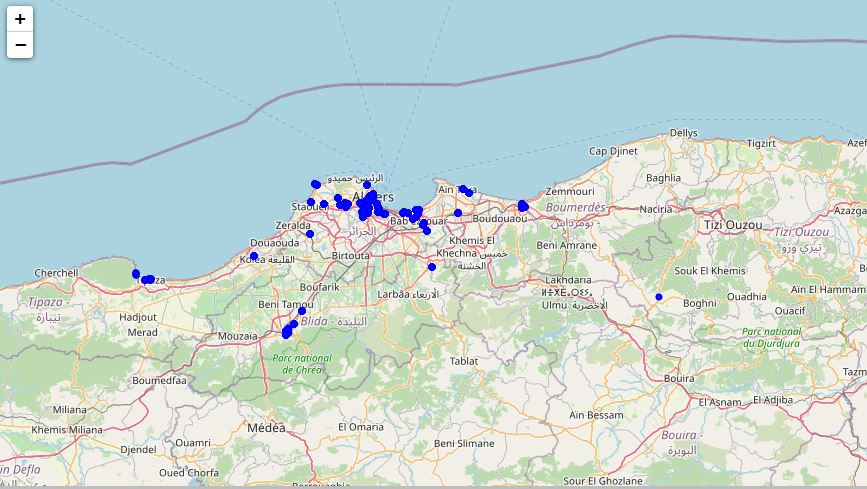

### Data Analysis

In [74]:
# venues count per neiborhood 
grouped = algiers_venues.groupby('Neighborhood').Venue.count().to_frame()
grouped.sort_values('Venue',ascending=False).reset_index()

Neighborhood  Venue
0             Birtouta     79
1          Baba Hassen     79
2               Douera     79
3               Draria     79
4           Aïn Bénian     77
5             Staoueli     77
6              Chéraga     77
7          Ouled Fayet     77
8          El Mouradia     75
9                Hydra     75
10             Zéralda     75
11     Djasr Kasentina     75
12     Bir Mourad Raïs     75
13              Baraki     75
14           Birkhadem     75
15      Les Eucalyptus     73
16        Oued Koriche     73
17          El Harrach     73
18           Oued Smar     73
19        Sidi M'Hamed     73
20        Alger Centre     73
21        Dely Ibrahim     73
22           Bologhine     73
23         Bab El Oued     73
24         Bab Ezzouar     73
25          Ben Aknoun     73
26        Beni Messous     73
27              Casbah     73
28        Dar El Beïda     73
29     Bordj El Kiffan     73
30            Bourouba     73
31           Bouzareah     73
32         Hussein Dey     71
33             Haraoua     71
34        Raïs Hamidou     71
35  Mohamed Belouizdad     71
36      Bordj El Bahri     70
37             Reghaïa     69
38            Aïn Taya     68

In [ ]:
# Venues retrieved per neighborhood range from 68 to 79 So it venues number have no effect until now.

#### filtering restaurans

In [75]:
algiers_venues['Venue Category'].unique()

array(['Church', 'Park', 'BBQ Joint', 'French Restaurant',
       'Indian Restaurant', 'Plaza', 'History Museum', 'Burger Joint',
       'Hotel', 'Falafel Restaurant', 'Lounge', 'Turkish Restaurant',
       'Brasserie', 'Theater', 'Bar', 'Resort', 'Lighthouse',
       'Restaurant', 'Art Museum', 'Spa', 'Seafood Restaurant', 'Diner',
       'Salad Place', 'Tea Room', 'Sandwich Place', 'Café', 'Steakhouse',
       'Campground', 'Recreation Center', 'Dive Spot',
       'African Restaurant', 'Coffee Shop', 'Shopping Mall',
       'Mediterranean Restaurant', 'Italian Restaurant',
       'Airport Terminal', 'Construction & Landscaping', 'Grocery Store',
       'Big Box Store', 'Middle Eastern Restaurant', 'Historic Site',
       'Beach', 'City', 'Harbor / Marina', 'Buffet'], dtype=object)

In [101]:
restaurants = algiers_venues[(algiers_venues['Venue Category'].str.contains('Restaurant'))|
               (algiers_venues['Venue Category'].apply(lambda x : x in ['Sandwich Place','Buffet','BBQ Joint','Steakhouse','Diner','Salad Place']))]
restaurants.rename(columns={'Venue':'Restaurant','Venue Category':'Category','Venue Latitude':'Restaurant Latitude',
                            'Venue Longitude':'Restaurant Longitude'},inplace=True)
restaurants.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
2   Bab El Oued              36.790665                3.049736   
3   Bab El Oued              36.790665                3.049736   
4   Bab El Oued              36.790665                3.049736   
9   Bab El Oued              36.790665                3.049736   
11  Bab El Oued              36.790665                3.049736   

                 Restaurant  Restaurant Latitude  Restaurant Longitude  \
2   Restaurant Le Thyrolien            36.775188              3.058731   
3                  CARACOYA            36.766672              3.053610   
4                 Taj Mahal            36.755626              2.968600   
9                  El Shami            36.760448              2.981543   
11              Le Bosphore            36.755545              3.030773   

              Category  
2            BBQ Joint  
3    French Restaurant  
4    Indian Restaurant  
9   Falafel Restaurant  
11  Turkish Restaurant

In [92]:
print('we have {} different restaurant in algiers area'.format(restaurants.shape[0]))

we have 1260 different restaurant in algiers area


### putting restaurants into categories 

In [130]:
gro = restaurants.groupby('Category').Restaurant.count().to_frame().reset_index().sort_values('Restaurant',ascending=False)
gro

Category  Restaurant
5           French Restaurant         234
10                 Restaurant         213
3                       Diner         117
15         Turkish Restaurant         117
13         Seafood Restaurant          90
6           Indian Restaurant          78
14                 Steakhouse          78
1                   BBQ Joint          58
12             Sandwich Place          58
8    Mediterranean Restaurant          42
0          African Restaurant          39
4          Falafel Restaurant          39
7          Italian Restaurant          39
11                Salad Place          39
9   Middle Eastern Restaurant          18
2                      Buffet           1

### categorizing restaurants depanding on neighborhood 

In [129]:
gro2 = restaurants.groupby('Neighborhood').Restaurant.count().to_frame().reset_index().sort_values('Restaurant',ascending=False)
gro2

Neighborhood  Restaurant
23              Draria          34
5          Baba Hassen          34
22              Douera          34
37            Staoueli          33
1           Aïn Bénian          33
35             Reghaïa          33
18             Chéraga          33
33         Ouled Fayet          33
11            Birtouta          33
27         Hussein Dey          32
24          El Harrach          32
25         El Mouradia          32
26             Haraoua          32
0         Alger Centre          32
28               Hydra          32
29      Les Eucalyptus          32
31        Oued Koriche          32
32           Oued Smar          32
34        Raïs Hamidou          32
36        Sidi M'Hamed          32
30  Mohamed Belouizdad          32
19        Dar El Beïda          32
21     Djasr Kasentina          32
9      Bir Mourad Raïs          32
2             Aïn Taya          32
3          Bab El Oued          32
4          Bab Ezzouar          32
6               Baraki          32
7           Ben Aknoun          32
8         Beni Messous          32
10           Birkhadem          32
20        Dely Ibrahim          32
12           Bologhine          32
13      Bordj El Bahri          32
14     Bordj El Kiffan          32
15            Bourouba          32
16           Bouzareah          32
17              Casbah          32
38             Zéralda          32

### Visualization results

<Figure size 432x288 with 0 Axes>

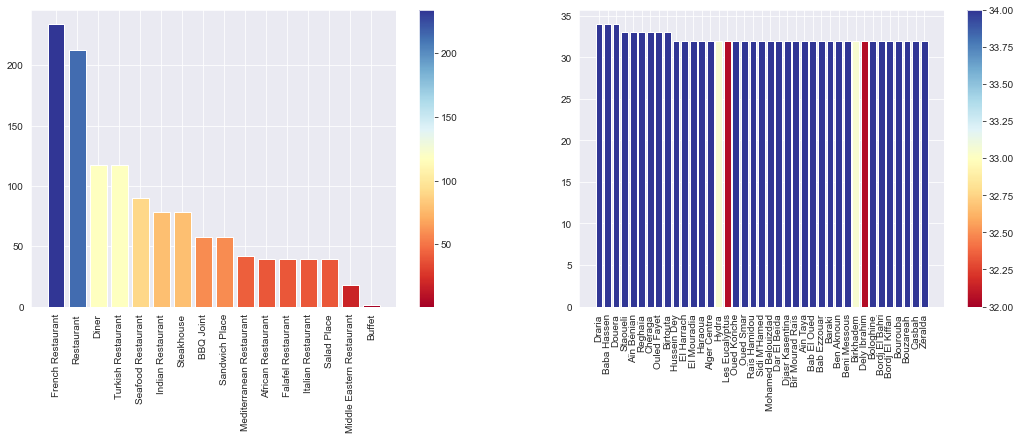

In [139]:

# Plotting Categories

# colormap 1 
y=gro['Restaurant']
colors = cm.RdYlBu(y/ float(max(y)))
plot = plt.scatter(y, y, c = y, cmap = 'RdYlBu')
plt.clf()  

# colormap 2 

y2=gro2['Restaurant']
colors2 = cm.RdYlBu(y/ float(max(y2)))
plot2 = plt.scatter(y2, y2, c = y2, cmap = 'RdYlBu')
plt.clf() 

# creating a figure 
plt.figure(figsize=(18,12))

# First subplot 
ax1= plt.subplot(2,2,1)
plt.colorbar(plot)
plt.bar(gro['Category'],gro['Restaurant'],color=colors)
plt.xticks(rotation='vertical')

# Second subplot 
ax2= plt.subplot(2,2,2)
plt.colorbar(plot2)
plt.bar(gro2['Neighborhood'],gro2['Restaurant'],color=colors2)
plt.xticks(rotation='vertical')

plt.show()

In [145]:
# Analysis
restaurants_onehot = pd.get_dummies(restaurants[['Category']], prefix="", prefix_sep="")
restaurants_onehot['Neighborhood'] = restaurants['Neighborhood'] 
neighb_columns = [restaurants_onehot.columns[-1]] + list(restaurants_onehot.columns[:-1])
restaurants_onehot = restaurants_onehot[neighb_columns]
restaurants_onehot.head()

Neighborhood  African Restaurant  BBQ Joint  Buffet  Diner  \
2   Bab El Oued                   0          1       0      0   
3   Bab El Oued                   0          0       0      0   
4   Bab El Oued                   0          0       0      0   
9   Bab El Oued                   0          0       0      0   
11  Bab El Oued                   0          0       0      0   

    Falafel Restaurant  French Restaurant  Indian Restaurant  \
2                    0                  0                  0   
3                    0                  1                  0   
4                    0                  0                  1   
9                    1                  0                  0   
11                   0                  0                  0   

    Italian Restaurant  Mediterranean Restaurant  Middle Eastern Restaurant  \
2                    0                         0                          0   
3                    0                         0                          0   
4                    0                         0                          0   
9                    0                         0                          0   
11                   0                         0                          0   

    Restaurant  Salad Place  Sandwich Place  Seafood Restaurant  Steakhouse  \
2            0            0               0                   0           0   
3            0            0               0                   0           0   
4            0            0               0                   0           0   
9            0            0               0                   0           0   
11           0            0               0                   0           0   

    Turkish Restaurant  
2                    0  
3                    0  
4                    0  
9                    0  
11                   1

In [146]:
# grouping neighborhoods
rest_grouped = restaurants_onehot.groupby('Neighborhood').mean().reset_index()
rest_grouped

Neighborhood  African Restaurant  BBQ Joint    Buffet     Diner  \
0         Alger Centre            0.031250   0.062500  0.000000  0.093750   
1           Aïn Bénian            0.030303   0.030303  0.000000  0.090909   
2             Aïn Taya            0.031250   0.062500  0.000000  0.093750   
3          Bab El Oued            0.031250   0.062500  0.000000  0.093750   
4          Bab Ezzouar            0.031250   0.062500  0.000000  0.093750   
5          Baba Hassen            0.029412   0.029412  0.000000  0.088235   
6               Baraki            0.031250   0.031250  0.000000  0.093750   
7           Ben Aknoun            0.031250   0.031250  0.000000  0.093750   
8         Beni Messous            0.031250   0.031250  0.000000  0.093750   
9      Bir Mourad Raïs            0.031250   0.031250  0.000000  0.093750   
10           Birkhadem            0.031250   0.031250  0.000000  0.093750   
11            Birtouta            0.030303   0.030303  0.000000  0.090909   
12           Bologhine            0.031250   0.031250  0.000000  0.093750   
13      Bordj El Bahri            0.031250   0.062500  0.000000  0.093750   
14     Bordj El Kiffan            0.031250   0.062500  0.000000  0.093750   
15            Bourouba            0.031250   0.062500  0.000000  0.093750   
16           Bouzareah            0.031250   0.031250  0.000000  0.093750   
17              Casbah            0.031250   0.062500  0.000000  0.093750   
18             Chéraga            0.030303   0.030303  0.000000  0.090909   
19        Dar El Beïda            0.031250   0.062500  0.000000  0.093750   
20        Dely Ibrahim            0.031250   0.031250  0.000000  0.093750   
21     Djasr Kasentina            0.031250   0.031250  0.000000  0.093750   
22              Douera            0.029412   0.029412  0.000000  0.088235   
23              Draria            0.029412   0.029412  0.000000  0.088235   
24          El Harrach            0.031250   0.062500  0.000000  0.093750   
25         El Mouradia            0.031250   0.031250  0.000000  0.093750   
26             Haraoua            0.031250   0.062500  0.000000  0.093750   
27         Hussein Dey            0.031250   0.062500  0.000000  0.093750   
28               Hydra            0.031250   0.031250  0.000000  0.093750   
29      Les Eucalyptus            0.031250   0.062500  0.000000  0.093750   
30  Mohamed Belouizdad            0.031250   0.062500  0.000000  0.093750   
31        Oued Koriche            0.031250   0.062500  0.000000  0.093750   
32           Oued Smar            0.031250   0.062500  0.000000  0.093750   
33         Ouled Fayet            0.030303   0.030303  0.000000  0.090909   
34        Raïs Hamidou            0.031250   0.062500  0.000000  0.093750   
35             Reghaïa            0.030303   0.060606  0.030303  0.090909   
36        Sidi M'Hamed            0.031250   0.062500  0.000000  0.093750   
37            Staoueli            0.030303   0.030303  0.000000  0.090909   
38             Zéralda            0.031250   0.031250  0.000000  0.093750   

    Falafel Restaurant  French Restaurant  Indian Restaurant  \
0             0.031250           0.187500           0.062500   
1             0.030303           0.181818           0.060606   
2             0.031250           0.187500           0.062500   
3             0.031250           0.187500           0.062500   
4             0.031250           0.187500           0.062500   
5             0.029412           0.176471           0.058824   
6             0.031250           0.187500           0.062500   
7             0.031250           0.187500           0.062500   
8             0.031250           0.187500           0.062500   
9             0.031250           0.187500           0.062500   
10            0.031250           0.187500           0.062500   
11            0.030303           0.181818           0.060606   
12            0.031250           0.187500           0.062500   
13            0.031250           

In [148]:
num_top_venues = 5

for hood in rest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = rest_grouped[rest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alger Centre----
                venue  freq
0   French Restaurant  0.19
1          Restaurant  0.16
2               Diner  0.09
3  Turkish Restaurant  0.09
4           BBQ Joint  0.06


----Aïn Bénian----
                venue  freq
0   French Restaurant  0.18
1          Restaurant  0.18
2               Diner  0.09
3  Seafood Restaurant  0.09
4  Turkish Restaurant  0.09


----Aïn Taya----
                venue  freq
0   French Restaurant  0.19
1          Restaurant  0.16
2               Diner  0.09
3  Turkish Restaurant  0.09
4           BBQ Joint  0.06


----Bab El Oued----
                venue  freq
0   French Restaurant  0.19
1          Restaurant  0.16
2               Diner  0.09
3  Turkish Restaurant  0.09
4           BBQ Joint  0.06


----Bab Ezzouar----
                venue  freq
0   French Restaurant  0.19
1          Restaurant  0.16
2               Diner  0.09
3  Turkish Restaurant  0.09
4           BBQ Joint  0.06


----Baba Hassen----
                venue  freq
0   F

# Conclusion 

So as we've explored our dataset in several ways and we come to a conclusion that in each neighborhood there is almost the same restaurants count,so it doesn't matter where the business owner will launch it's restaurant.
As For Type of restaurant , according to the data we see that French restaurant are the most frequent, if the business owner has a Competitional mindset we recommend that he start a french restaurant, otherwise there is indian and turkich food domains that can be very beneficial.